In [9]:
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.constants import c

In [8]:
cfg = np.load('../../constants/config.npy', allow_pickle=True).item()
nfft = cfg['nfft']
freq = cfg['freq']
dist_vec = cfg['dist_vec']
rbw = cfg['rbw']
nstep = freq.shape[0]

In [7]:
r = 2 # range in meters

In [37]:
f_vib = 20e3
a_vib = 10e-6
phi_vib = 0
t = np.arange(nstep) * 1 / (rbw * 1000)
omega = freq * 2 * np.pi
vib = a_vib * np.sin(2 * np.pi * f_vib * t + phi_vib)
delta_t = 2 * (r + vib) / c
delta_t_raw = 2 * r / c
phi = np.multiply(omega, delta_t)
phi_raw = np.multiply(omega, delta_t_raw)
iq_sample = np.exp(-1j * phi)
iq_sample_raw = np.exp(-1j * phi_raw)

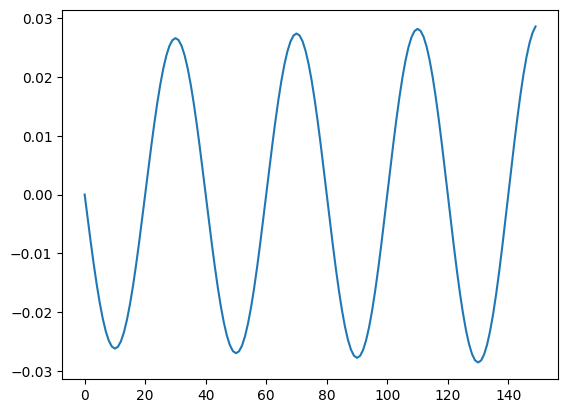

In [39]:
plt.plot(np.angle(iq_sample) - np.angle(iq_sample_raw))

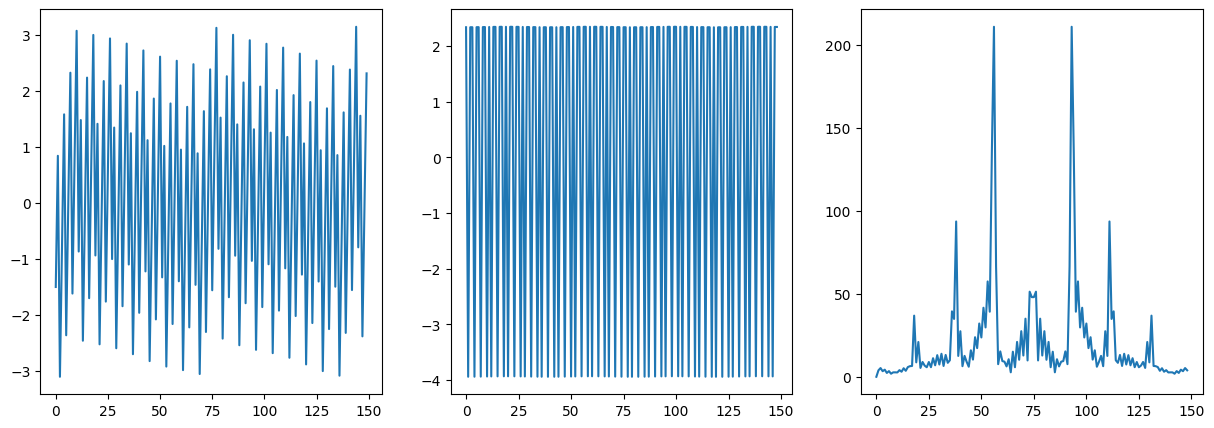

In [90]:
# plt.plot(np.unwrap(np.angle(iq_sample)))
# plt.plot(np.angle(iq_sample))
# plt.plot(np.diff(np.angle(iq_sample)))
# plt.plot(np.diff(np.unwrap(np.angle(iq_sample))))

# phase = np.unwrap(np.angle(iq_sample))
phase = np.angle(iq_sample)
d_phase = np.diff(phase)
d_phi_fft = np.fft.fft(d_phase)
d_phi_fft[0] = 0
plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(phase)
plt.subplot(1, 3, 2)
plt.plot(d_phase)
plt.subplot(1, 3, 3)
plt.plot(np.abs(d_phi_fft))

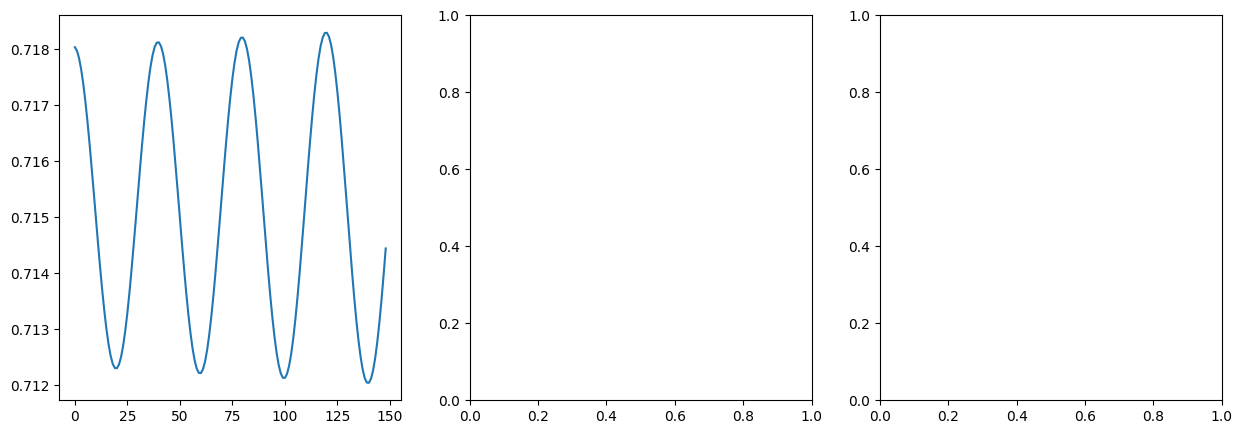

In [100]:
i_sample, q_sample = np.real(iq_sample), np.imag(iq_sample)
d_iq = np.zeros(nstep)
for k in range(1, nstep):
    d_iq[k] = (i_sample[k] * (q_sample[k] - q_sample[k - 1]) - q_sample[k] * (i_sample[k] - i_sample[k - 1])) / (i_sample[k] ** 2 + q_sample[k] ** 2)

phase_reconstruct = np.zeros(nstep)
for k in range(1, nstep):
    phase_reconstruct[k] = phase_reconstruct[k - 1] + d_iq[k]

plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(d_iq[1:])

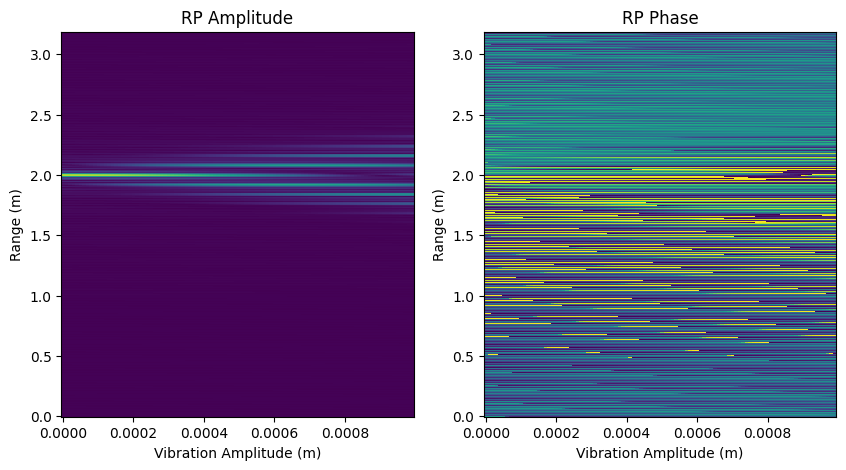

In [51]:
def get_rp(f_vib = 20e3, a_vib = 1e-3, phi_vib = 0):
    t = np.arange(nstep) * 1 / (rbw * 1000)
    omega = freq * 2 * np.pi
    vib = a_vib * np.sin(2 * np.pi * f_vib * t + phi_vib)
    delta_t = 2 * (r + vib) / c
    phi = np.multiply(omega, delta_t)
    iq_sample = np.exp(-1j * phi)
    rp = np.fft.ifft(iq_sample, n=nfft)
    return rp

a_vibs = np.arange(100) * 1e-5
rp_a_vibs = np.zeros((a_vibs.shape[0], nfft), dtype=np.complex64)
for i in range(a_vibs.shape[0]):
    f_vib = a_vibs[i]
    rp = get_rp(a_vib=f_vib)
    rp_a_vibs[i, :] = rp

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(a_vibs, dist_vec, np.abs(rp_a_vibs).T)
axes[0].set_xlabel('Vibration Amplitude (m)')
axes[0].set_ylabel('Range (m)')
axes[0].set_title('RP Amplitude')
# axes[1].pcolormesh(np.arange(a_vibs.shape[0]), dist_vec, np.unwrap(np.angle(rp_a_vibs.T), axis=0))
axes[1].set_xlabel('Vibration Amplitude (m)')
axes[1].set_ylabel('Range (m)')
axes[1].set_title('RP Phase')
axes[1].pcolormesh(a_vibs, dist_vec, np.angle(rp_a_vibs.T))

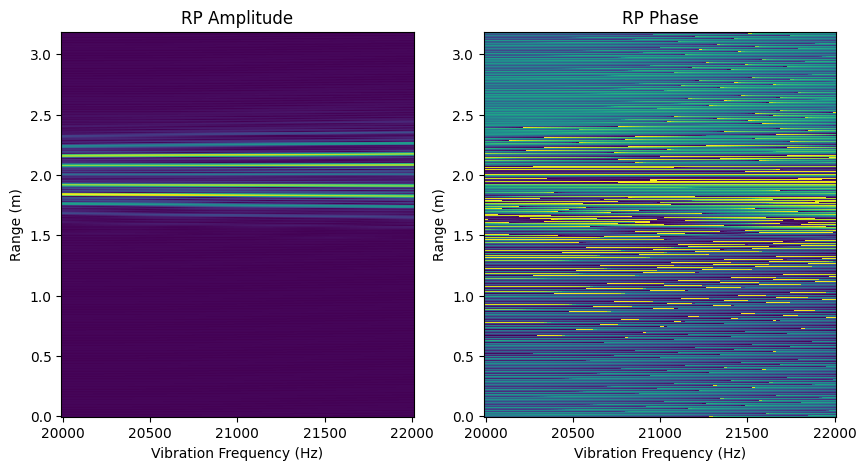

In [52]:
f_vibs = np.linspace(20e3, 22e3, 100)
rp_f_vibs = np.zeros((f_vibs.shape[0], nfft), dtype=np.complex64)
for i in range(f_vibs.shape[0]):
    f_vib = f_vibs[i]
    rp = get_rp(f_vib=f_vib)
    rp_f_vibs[i, :] = rp

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(f_vibs, dist_vec, np.abs(rp_f_vibs).T)
axes[0].set_xlabel('Vibration Frequency (Hz)')
axes[0].set_ylabel('Range (m)')
axes[0].set_title('RP Amplitude')

axes[1].set_xlabel('Vibration Frequency (Hz)')
axes[1].set_ylabel('Range (m)')
axes[1].set_title('RP Phase')
axes[1].pcolormesh(f_vibs, dist_vec, np.angle(rp_f_vibs.T))

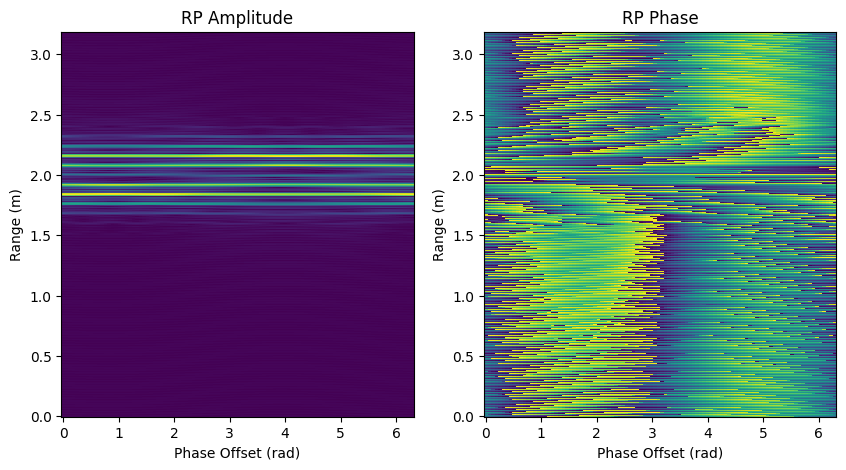

In [56]:
phi_vibs = np.linspace(0, 2*np.pi, 100)
rp_phi_vibs = np.zeros((phi_vibs.shape[0], nfft), dtype=np.complex64)
for i in range(phi_vibs.shape[0]):
    phi_vib = phi_vibs[i]
    rp = get_rp(phi_vib=phi_vib)
    rp_phi_vibs[i, :] = rp

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(phi_vibs, dist_vec, np.abs(rp_phi_vibs).T)
axes[0].set_xlabel('Phase Offset (rad)')
axes[0].set_ylabel('Range (m)')
axes[0].set_title('RP Amplitude')

axes[1].set_xlabel('Phase Offset (rad)')
axes[1].set_ylabel('Range (m)')
axes[1].set_title('RP Phase')
axes[1].pcolormesh(phi_vibs, dist_vec, np.angle(rp_phi_vibs.T))

Ideas:
1. Phase derivative (difference) and take FFT
2. Try chirp